In [1]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from generate_data import ARData, fixed_ar_coefficients
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import os
from torchvision.transforms import transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#read features from trackmate extracted csv for lstm autencoder 

In [2]:
#ZXY = Altered point
num_epochs = 200
learning_rate = 0.001
batch_size = 64
dtype = torch.long
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
device

device(type='cuda', index=0)

In [6]:
data = pd.read_csv (r'Z:\DataResult\20200618\Urine\sc_2\r1\ImageJ\Spots_in_tracks_statistics.csv', low_memory=False,index_col=None, header=None)

In [16]:
data = pd.read_csv (r'C:\Users\ZXY\OneDrive\Desktop\Spots in tracks statistics.csv', low_memory=False,index_col=None, header=None)

In [17]:
data = pd.read_csv (r'Z:\RawData\20200918\beads_1\BgSub\ImageJ\Spots in tracks statistics.csv', low_memory=False,index_col=None, header=None)

In [18]:
data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
1,ID624489,624489,0,243.200,70.265,61.595,0,0,0,5,...,-10921639,1356.206,976,272,4096,131552,1014.718,5.080,0.685,1.087
2,ID625852,625852,0,241.099,70.358,59.526,0,1,1,5,...,-10921639,1326.680,928,256,3968,128688,1020.710,5.106,0.697,1.068
3,ID625696,625696,0,221.939,70.072,57.495,0,2,2,5,...,-10921639,1264.990,848,224,3680,122704,919.347,5.105,0.668,1.103
4,ID624333,624333,0,216.233,70.039,55.384,0,3,3,5,...,-10921639,1222.598,848,208,3408,118592,884.482,5.085,0.679,1.118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180909,ID805374,805374,1030,44.587,237.680,173.385,0,998,998,5,...,-10921639,395.216,368,112,864,38336,199.869,5.088,0.378,1.085
180910,ID805783,805783,1030,80.573,237.410,170.942,0,999,999,5,...,-10921639,607.670,560,96,1456,58944,365.557,5.131,0.467,1.058
180911,ID804569,804569,1031,41.442,916.603,228.651,0,995,995,5,...,-10921639,358.268,320,112,832,34752,185.782,5.105,0.367,1.035
180912,ID805587,805587,1031,40.321,915.851,227.360,0,996,996,5,...,-10921639,360.907,320,112,816,35008,163.690,5.154,0.368,1.187


In [19]:
data = data.to_numpy()
true_data = data[1:,2:].astype(np.float)#drop header and labelID

true_data  
# 0,&nbsp;&nbsp;1,&nbsp;&nbsp;&nbsp;&nbsp;2,&nbsp;&nbsp;&nbsp;&nbsp;3,&nbsp;&nbsp;&nbsp;&nbsp;4,&nbsp;&nbsp;&nbsp;&nbsp;5,&nbsp;&nbsp;6,&nbsp;&nbsp;7,&nbsp;&nbsp;8,&nbsp;&nbsp;9,&nbsp;&nbsp;&nbsp;&nbsp;10,&nbsp;&nbsp;&nbsp;&nbsp;11,&nbsp;&nbsp;&nbsp;&nbsp;12,&nbsp;&nbsp;&nbsp;&nbsp;13,&nbsp;&nbsp;&nbsp;&nbsp;14,&nbsp;&nbsp;&nbsp;&nbsp;15,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;16,&nbsp;&nbsp;&nbsp;&nbsp;17,&nbsp;&nbsp;18
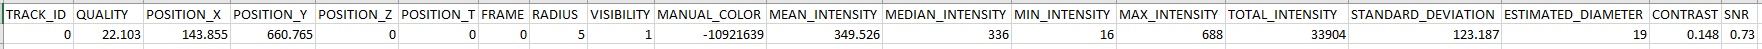

In [20]:
#select features
selected_data = true_data[:,[0,1,2,3,10,11,12,13,14,15,17,18]]

In [21]:
selected_data[:,1] = selected_data[:,1]*10
selected_data[:,7] = selected_data[:,7]/10
selected_data[:,8] = selected_data[:,8]/100
selected_data[:,10] = selected_data[:,10]*1000
selected_data[:,11] = selected_data[:,11]*1000

In [22]:
#drop tracks whose length fewer than n, divide long tracks to several n-length tracks 
def padding_truncate(data, t = 200):
    #return data with shape(m,t,n), m is sample numbers, t is length of tracks, n is feature numbers
    count = 1
    n = data.shape[1]
    dataset = np.zeros((1,t,n))
    for i in range(1,data.shape[0],1):    
        if data[i,0] == data[i-1,0]:
            count+=1
        else:
                count = 1
                
        if count == t:
            dataset = np.append(dataset, np.expand_dims(data[i+1-t:i+1],axis = 0), axis = 0)
            count = 0
        else:
                pass
    
    dataset = dataset[1:]
    return dataset

In [23]:
dataset = padding_truncate(selected_data,500)

In [24]:
dataset.shape

(147, 500, 12)

In [25]:
track_ids = dataset[:,1,0]


In [26]:
track_ids = set(track_ids)

In [27]:
len(track_ids)


145

In [28]:
true_data[0,10]

1356.206

In [29]:
dataset_test = padding_truncate(true_data)
np.mean(dataset_test[:,:,10])

3085.9930665220822

In [103]:
dataset = dataset[:,:,1:]

In [104]:
# custom dataset
#lstm autoencoder dataset, y is the same as x
class MyDataset(Dataset):
    def __init__(self, datax, labels, transforms=None):
        self.X = datax
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (self.X.shape[0])
    
    def __getitem__(self, i):
        #print(i)
        i= i%self.X.shape[0]

        data = self.X[i]
        #data = self.X
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return (data,data)

In [105]:
train_data = MyDataset(dataset,None)

# dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [106]:
for i, (X_batch, labels_batch )in enumerate(train_loader):
    print(X_batch.shape)
    print(labels_batch)
    break

torch.Size([64, 200, 11])
tensor([[[2810.5300, 1180.0900,   95.2800,  ..., 1323.9190,  729.0000,
           851.0000],
         [3037.6500, 1180.1550,   95.7590,  ..., 1427.5110,  724.0000,
           855.0000],
         [2940.7100, 1180.1190,   96.0670,  ..., 1377.9730,  730.0000,
           853.0000],
         ...,
         [1643.4400, 1215.5720,  175.0550,  ...,  771.3690,  621.0000,
           869.0000],
         [1655.7500, 1215.9780,  175.3120,  ...,  781.9890,  616.0000,
           849.0000],
         [1618.6300, 1215.9300,  175.7700,  ...,  750.8910,  617.0000,
           878.0000]],

        [[ 175.0400,   78.5080,  234.6980,  ...,  128.3490,  139.0000,
           749.0000],
         [ 153.7000,   77.4790,  233.1890,  ...,  128.7060,   61.0000,
           314.0000],
         [ 173.4600,   77.7490,  232.9190,  ...,  140.3770,   90.0000,
           383.0000],
         ...,
         [ 196.0100,   78.8880,  231.2440,  ...,  136.5460,  137.0000,
           536.0000],
         [ 231

In [107]:
# predict
def predict(model, loader):
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_predicted = []
        labels_total = []       
        
        for images, labels in loader:
            images = images.to(device,dtype=torch.float)
            labels = labels.squeeze().to(device)

            outputs, _ = model.forward(images)
                
            _, predicted = torch.max(outputs.data, 1)# _ are max values, predicts are their indexs
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted += predicted.cpu().numpy().tolist()
            labels_total += labels.cpu().numpy().tolist()
#             print(outputs)
#             print('predicted',predicted)
#             print('labels', labels)
#             print(correct)
#             print(total)
#             print(predicted == labels)

        print("Accuracy: {}%" .format(100* correct/total),'correct', correct, 'total',total)
    model.train()
    return all_predicted, labels_total, format(100* correct/total)

In [108]:
#####################
# Build model
#####################

# Here we define our model as a class
class CNN_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(CNN_LSTM, self).__init__()
        self.input_ch = input_ch
        self.ch1, self.ch2 = 16, 32 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.k1, self.k2 = 5, 5
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes

        self.cnn1 = nn.Conv2d(self.input_ch, self.ch1, self.k1)
        self.cnn2 = nn.Conv2d(self.ch1, self.ch2, self.k2)

        self.fc1 = nn.Linear(((10-self.k1+1)-self.k2+1)**2 * self.ch2, self.cnn_embed_dim) # 10 is image size
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.cnn1(cnn_in)
        x = nn.functional.relu(x)

        x = self.cnn2(x)
        x = nn.functional.relu(x)
        
#         print(x.shape)
        x = x.view(-1, ((10-self.k1+1)-self.k2+1)**2 * self.ch2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
#         print(x.shape)
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        embed = x

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed
    
class Linear_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Linear_LSTM, self).__init__()
        self.input_ch = input_ch 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes

        self.fc1 = nn.Linear(10*10, self.cnn_embed_dim, bias = True) # 10 is image size
#         self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
#         self.fc1.weight.data.fill_(0.01)
        self.softmax = nn.Softmax()
      
    #separate operations on each channel
    def divide_inputs(self,X):
        batch_size, timesteps, C, H, W = X.size()
        x  =  X.view(batch_size*timesteps, C, H*W)
        embed = self.fc1(x[:,0,:])

        for i in range(C-1):
            embed = torch.cat((embed,self.fc1(x[:,i+1,:])), dim = 1)

        return embed             

    def forward(self, X_stacked):
        
#         print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        
#         x  =  X_stacked.view(batch_size*timesteps, C*H*W)#need to be checked
        
#         x = self.fc1(x)
#         x = nn.functional.relu(x)
        x = self.divide_inputs(X_stacked)  
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        embed = x#here view may distort the X

        lstm_out, (h_n, h_c) = self.lstm(x)# -1 is timesteps here
                                           # here view distort the X
     
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed

#this model is constructed to mimic extracting 1d time information, checked
class Linear_CNN1D(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Linear_CNN1D, self).__init__()
        self.input_ch = input_ch         
        self.ch1, self.ch2, self.ch3 = 6, 16, 26 
        self.k1, self.k2, self.k3 = 5, 5, 3


        self.embed_dim = 1 #cnn-embedded dim 

        self.N_classes = N_classes

        self.cnn1 = nn.Conv1d(self.input_ch, self.ch1, self.k1, stride=2)
        self.cnn2 = nn.Conv1d(self.ch1, self.ch2, self.k2, stride=2)
        self.cnn3 = nn.Conv1d(self.ch2, self.ch3, self.k3, stride=2)
        
        self.fc1 = nn.Linear(1*10*10, self.embed_dim) # 10 is image size
        self.fc2 = nn.Linear(26, 8)
        self.fc3 = nn.Linear(8, self.N_classes)
        
        self.fc1.weight.data.fill_(0.01)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        

        batch_size, timesteps, C, H, W = X_stacked.size()
        x  =  X_stacked.view(batch_size*timesteps, C*H*W)#need to be checked
        
        x = self.fc1(x)
        #x = nn.functional.leaky_relu(x)

        x = x.view(batch_size, 1, -1)
        emd = x

        x = nn.functional.max_pool1d(self.cnn1(x),2)
        x = nn.functional.max_pool1d(self.cnn2(x),2)
        x = nn.functional.max_pool1d(self.cnn3(x),2)

        x = x.view(-1, self.num_flat_features(x))
        x = nn.functional.relu(self.fc2(x))

        y_pred = self.fc3(x)

        y_pred = self.softmax(y_pred)

        return y_pred, emd
    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
class CNN_ENCODER_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(CNN_ENCODER_LSTM, self).__init__()
        self.input_ch = input_ch
        self.ch1, self.ch2 = 4, 8 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.k1, self.k2 = 5, 5
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes
        
        self.encoder = nn.Sequential(
            nn.Conv2d(self.input_ch, self.ch1, self.k1),
            nn.ReLU(True),
            nn.Conv2d(self.ch1, self.ch2, self.k2),
            nn.ReLU(True)
            )

        self.fc1 = nn.Linear(((10-self.k1+1)-self.k2+1)**2 * self.ch2, self.cnn_embed_dim) # 10 is image size
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.encoder(cnn_in)
        
#         print(x.shape)
        x = x.view(-1, ((10-self.k1+1)-self.k2+1)**2 * self.ch2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
#         print(x.shape)
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        embed = x

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(4,8,kernel_size=5),
            nn.ReLU(True))
            
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(8,4,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(4,1,kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        embed = x
        x = self.decoder(x)

        return x, embed

In [109]:
#####################
# Build model
#####################
class newresnet(torch.nn.Module):
    def __init__(self):
        super(newresnet, self).__init__()

        self.newresnet18  = torchvision.models.resnet18(pretrained = True)
        # for param in self.newresnet18.parameters():
        #     param.requires_grad = False
        # here in_feature is 512*block.expansion
        num_ftrs = self.newresnet18.fc.in_features 

        # remove the last fc layer
        # myresnet = torch.nn.Sequential(*list(myresnet.children())[:-1])
        self.newresnet18.fc = torch.nn.Identity()
        self.fc = torch.nn.Linear(num_ftrs, num_classes)
    def forward(self,x):
        x = self.newresnet18(x)
        # x = torch.flatten(x,1)
        x = self.fc(x)
        return x

class Resnet_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Resnet_LSTM, self).__init__()
        self.input_ch = input_ch 
        self.h_d = 16
        self.num_layers = 2
        self.N_classes = N_classes
        
        self.newresnet18  = torchvision.models.resnet18(pretrained = True)

        self.cnn_embed_dim = self.newresnet18.fc.in_features 

        self.newresnet18.fc = torch.nn.Identity()
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        X_stacked = torch.cat((X_stacked,X_stacked,X_stacked), dim = 2)
        batch_size, timesteps, C, H, W = X_stacked.size()
        
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.newresnet18(cnn_in)

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred

In [110]:
#####################
# Build model
#####################
class LSTM_Autoencoder(nn.Module):
    def __init__(self, features_in, input_ch = 1):
        super(LSTM_Autoencoder, self).__init__()
        self.input_ch = input_ch
        self.features_dim = features_in #cnn-embedded dim 
        self.h_d = self.features_dim # be aware of here ZXY 
        self.num_layers = 2
        
        self.lstm_en = nn.LSTM(self.features_dim, self.h_d, self.num_layers)
        self.lstm_de = nn.LSTM(self.h_d, self.features_dim, self.num_layers)
        
        self.softmax = nn.Softmax()

    def lstm_encoder(self, X_stacked):
        
        #print(X_stacked.size())
        batch_size, timesteps, features_in = X_stacked.size()
        extra = []
        
        x = X_stacked.permute(1,0,2)

        rep, (h_n, h_c) = self.lstm_en(x)# -1 is timesteps here

        return rep[-1, :, :].unsqueeze(0), extra

    def forward(self, X_stacked):
        
        batch_size, timesteps, features_in = X_stacked.size()
        rep, extra = self.lstm_encoder(X_stacked)
        decoder_generated = []
        
        for i in range(timesteps):
            rep, (h_n, h_c) = self.lstm_en(rep)
            decoder_generated.append(rep)
        
        decoder_generated.reverse()
        decoder_generated = torch.stack(decoder_generated, dim = 0)
        decoder_generated = decoder_generated.squeeze()
        decoder_generated = decoder_generated.permute(1,0,2)
#         decoder_generated = decoder_generated.view(batch_size*timesteps,-1)
        return decoder_generated, extra

In [111]:
#define Root Mean Squared Logarithmic Error Loss
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [112]:
#https://github.com/tuantle/regression-losses-pytorch
#https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))


class XTanhLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(ey_t * torch.tanh(ey_t))


class XSigmoidLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(2 * ey_t / (1 + torch.exp(-ey_t)) - ey_t)

In [113]:
# # for loading
# autoenoder = Autoencoder()# (use the class to initialize the model)
# autoenoder.to(device)
# autoenoder.eval()
# fname = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\Autoencoder\autoencoder.pt'
# autoenoder.load_state_dict(torch.load(fname), strict = False)

In [114]:
# model = CNN_LSTM()
# model = Resnet_LSTM()
# model = Linear_LSTM()
# model = Linear_CNN1D()
# model = CNN_ENCODER_LSTM()
model = LSTM_Autoencoder(features_in = dataset.shape[2])
model.to(device)

LSTM_Autoencoder(
  (lstm_en): LSTM(11, 11, num_layers=2)
  (lstm_de): LSTM(11, 11, num_layers=2)
  (softmax): Softmax(dim=None)
)

In [115]:
# fname = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\Autoencoder\autoencoder.pt'
# model.load_state_dict(torch.load(fname), strict = False)

In [116]:
# loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()
loss_fun = LogCoshLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# optimizer = torch.optim.Adam([
#                               {'params':model.fc1.parameters(),'lr': learning_rate/1000},
#                               {'params':model.lstm_en.parameters()},
#                               {'params':model.lstm_de.parameters()},
#                               {'params':model.fc2.parameters()},
#                               {'params':model.encoder.parameters(), 'lr': 0},
#                              ], 
#                              lr = learning_rate)

In [117]:
#For updating learning rate
def update_lr(opt, divide = 2):
    for param_group in opt.param_groups:
        param_group['lr'] = param_group['lr']/divide

In [118]:
# Print model's state_dict
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

LSTM_Autoencoder(
  (lstm_en): LSTM(11, 11, num_layers=2)
  (lstm_de): LSTM(11, 11, num_layers=2)
  (softmax): Softmax(dim=None)
)
Model's state_dict:
lstm_en.weight_ih_l0 	 torch.Size([44, 11])
lstm_en.weight_hh_l0 	 torch.Size([44, 11])
lstm_en.bias_ih_l0 	 torch.Size([44])
lstm_en.bias_hh_l0 	 torch.Size([44])
lstm_en.weight_ih_l1 	 torch.Size([44, 11])
lstm_en.weight_hh_l1 	 torch.Size([44, 11])
lstm_en.bias_ih_l1 	 torch.Size([44])
lstm_en.bias_hh_l1 	 torch.Size([44])
lstm_de.weight_ih_l0 	 torch.Size([44, 11])
lstm_de.weight_hh_l0 	 torch.Size([44, 11])
lstm_de.bias_ih_l0 	 torch.Size([44])
lstm_de.bias_hh_l0 	 torch.Size([44])
lstm_de.weight_ih_l1 	 torch.Size([44, 11])
lstm_de.weight_hh_l1 	 torch.Size([44, 11])
lstm_de.bias_ih_l1 	 torch.Size([44])
lstm_de.bias_hh_l1 	 torch.Size([44])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [2596926745480, 2596926745240, 2596924709288,

In [119]:
for param_group in optimizer.param_groups:
    a = param_group['lr']
    print(a)

0.01


In [120]:
#####################
# Train model
#####################

hist = np.zeros(num_epochs)
hist_2 = np.zeros(num_epochs)
accuracy_train = np.zeros(num_epochs)
accuracy_test = np.zeros(num_epochs)
accuracy_val = np.zeros(num_epochs)
total_step = len(train_loader)

flag = False

for epoch in range(num_epochs):
    for i, (X_batch, labels_batch )in enumerate(train_loader):
        #X_batch = X_batch.permute(1,0,2,3)
        #print(X_batch.shape)
#         
        X_batch = X_batch.to(device, dtype=torch.float)
        labels_batch = labels_batch.to(device)

        #forward
        y_pred, embed = model.forward(X_batch)
#         print(y_pred.shape)
#         print(embed.shape)

#         print(y_pred.shape)
#         print(X_batch.shape)
#         print(labels_batch.shape)
        #loss function
        loss = loss_fn(y_pred, X_batch)
#         print(y_pred)
        #loss2 = loss_fn2(y_pred, labels_batch)
        hist[epoch] = loss.item()
        #why 0.6931
        optimizer.zero_grad()
        #backward 
        loss.backward()

        #optimize
        optimizer.step()

        if (i+1)%1 == 0:
            print("Epoch [{}/{}], Step[{}/{}] Loss:{:.4f}" 
                .format(epoch+1, num_epochs, i+1, total_step, loss.item() ))
#         _,__ , accuracy_train[epoch]= predict(model, train_loader)
#         _,__ , accuracy_test[epoch]= predict(model, test_loader)
#         _,__ , accuracy_val[epoch]= predict(model, val_loader)

#         if loss.item()<1.30:
#             flag = True
#             break
#     if flag:
#         break
        
#     if (epoch+1) > 200:   
#         if (epoch+1)%100 == 0:
#             update_lr(optimizer, 1.1)
    
        

Epoch [1/200], Step[1/17] Loss:1403664.2500
Epoch [1/200], Step[2/17] Loss:3184913.2500
Epoch [1/200], Step[3/17] Loss:1643791.3750
Epoch [1/200], Step[4/17] Loss:1185794.3750
Epoch [1/200], Step[5/17] Loss:1119393.5000
Epoch [1/200], Step[6/17] Loss:1763011.7500
Epoch [1/200], Step[7/17] Loss:773714.7500
Epoch [1/200], Step[8/17] Loss:1657404.7500
Epoch [1/200], Step[9/17] Loss:1908040.8750
Epoch [1/200], Step[10/17] Loss:2244463.7500
Epoch [1/200], Step[11/17] Loss:1561880.7500
Epoch [1/200], Step[12/17] Loss:1765271.1250
Epoch [1/200], Step[13/17] Loss:5818099.0000
Epoch [1/200], Step[14/17] Loss:3944721.7500
Epoch [1/200], Step[15/17] Loss:1457217.0000
Epoch [1/200], Step[16/17] Loss:1081403.8750
Epoch [1/200], Step[17/17] Loss:8842523.0000
Epoch [2/200], Step[1/17] Loss:1626858.1250
Epoch [2/200], Step[2/17] Loss:1375288.3750
Epoch [2/200], Step[3/17] Loss:924208.6875
Epoch [2/200], Step[4/17] Loss:1314991.3750
Epoch [2/200], Step[5/17] Loss:1459619.8750
Epoch [2/200], Step[6/17] 

Epoch [22/200], Step[8/17] Loss:1026842.6250
Epoch [22/200], Step[9/17] Loss:1805098.2500
Epoch [22/200], Step[10/17] Loss:4277378.0000
Epoch [22/200], Step[11/17] Loss:1219002.1250
Epoch [22/200], Step[12/17] Loss:1315884.1250
Epoch [22/200], Step[13/17] Loss:2924363.2500
Epoch [22/200], Step[14/17] Loss:3748002.0000
Epoch [22/200], Step[15/17] Loss:1536500.1250
Epoch [22/200], Step[16/17] Loss:1727824.1250
Epoch [22/200], Step[17/17] Loss:1646060.0000
Epoch [23/200], Step[1/17] Loss:8640776.0000
Epoch [23/200], Step[2/17] Loss:1847287.1250
Epoch [23/200], Step[3/17] Loss:2076060.6250
Epoch [23/200], Step[4/17] Loss:2114875.5000
Epoch [23/200], Step[5/17] Loss:2955992.7500
Epoch [23/200], Step[6/17] Loss:1258157.8750
Epoch [23/200], Step[7/17] Loss:2923785.0000
Epoch [23/200], Step[8/17] Loss:948054.3125
Epoch [23/200], Step[9/17] Loss:3871209.5000
Epoch [23/200], Step[10/17] Loss:3556028.2500
Epoch [23/200], Step[11/17] Loss:1269393.7500
Epoch [23/200], Step[12/17] Loss:1201642.3750


Epoch [43/200], Step[11/17] Loss:1090992.6250
Epoch [43/200], Step[12/17] Loss:1328598.0000
Epoch [43/200], Step[13/17] Loss:1037233.5625
Epoch [43/200], Step[14/17] Loss:3158075.2500
Epoch [43/200], Step[15/17] Loss:5190308.0000
Epoch [43/200], Step[16/17] Loss:1100420.1250
Epoch [43/200], Step[17/17] Loss:9984082.0000
Epoch [44/200], Step[1/17] Loss:2112844.0000
Epoch [44/200], Step[2/17] Loss:1926499.6250
Epoch [44/200], Step[3/17] Loss:1011238.5000
Epoch [44/200], Step[4/17] Loss:1130582.6250
Epoch [44/200], Step[5/17] Loss:2698073.5000
Epoch [44/200], Step[6/17] Loss:1554535.6250
Epoch [44/200], Step[7/17] Loss:762782.2500
Epoch [44/200], Step[8/17] Loss:1445195.5000
Epoch [44/200], Step[9/17] Loss:2155409.0000
Epoch [44/200], Step[10/17] Loss:679385.6250
Epoch [44/200], Step[11/17] Loss:1354783.3750
Epoch [44/200], Step[12/17] Loss:1909725.7500
Epoch [44/200], Step[13/17] Loss:10752376.0000
Epoch [44/200], Step[14/17] Loss:1719702.0000
Epoch [44/200], Step[15/17] Loss:3307924.500

Epoch [64/200], Step[14/17] Loss:844839.0000
Epoch [64/200], Step[15/17] Loss:1412774.0000
Epoch [64/200], Step[16/17] Loss:2752274.7500
Epoch [64/200], Step[17/17] Loss:1343333.1250
Epoch [65/200], Step[1/17] Loss:1266119.8750
Epoch [65/200], Step[2/17] Loss:865709.8750
Epoch [65/200], Step[3/17] Loss:2474774.2500
Epoch [65/200], Step[4/17] Loss:9424577.0000
Epoch [65/200], Step[5/17] Loss:1968224.1250
Epoch [65/200], Step[6/17] Loss:1557919.3750
Epoch [65/200], Step[7/17] Loss:1444280.7500
Epoch [65/200], Step[8/17] Loss:1420039.1250
Epoch [65/200], Step[9/17] Loss:2639439.2500
Epoch [65/200], Step[10/17] Loss:934745.3750
Epoch [65/200], Step[11/17] Loss:1304071.2500
Epoch [65/200], Step[12/17] Loss:4984722.5000
Epoch [65/200], Step[13/17] Loss:651039.6250
Epoch [65/200], Step[14/17] Loss:2253906.2500
Epoch [65/200], Step[15/17] Loss:2230869.2500
Epoch [65/200], Step[16/17] Loss:732558.1875
Epoch [65/200], Step[17/17] Loss:4343739.0000
Epoch [66/200], Step[1/17] Loss:3571729.2500
Epo

Epoch [85/200], Step[17/17] Loss:1596840.0000
Epoch [86/200], Step[1/17] Loss:1110929.5000
Epoch [86/200], Step[2/17] Loss:1085036.2500
Epoch [86/200], Step[3/17] Loss:3387545.5000
Epoch [86/200], Step[4/17] Loss:2282383.5000
Epoch [86/200], Step[5/17] Loss:2904655.0000
Epoch [86/200], Step[6/17] Loss:1189505.8750
Epoch [86/200], Step[7/17] Loss:1452307.1250
Epoch [86/200], Step[8/17] Loss:1944193.0000
Epoch [86/200], Step[9/17] Loss:2209854.0000
Epoch [86/200], Step[10/17] Loss:1174881.0000
Epoch [86/200], Step[11/17] Loss:3401516.7500
Epoch [86/200], Step[12/17] Loss:1663614.1250
Epoch [86/200], Step[13/17] Loss:2669120.5000
Epoch [86/200], Step[14/17] Loss:3714570.5000
Epoch [86/200], Step[15/17] Loss:962647.0625
Epoch [86/200], Step[16/17] Loss:7548797.0000
Epoch [86/200], Step[17/17] Loss:1207046.7500
Epoch [87/200], Step[1/17] Loss:1947259.0000
Epoch [87/200], Step[2/17] Loss:1674209.7500
Epoch [87/200], Step[3/17] Loss:2116014.0000
Epoch [87/200], Step[4/17] Loss:1880681.5000
Ep

Epoch [107/200], Step[1/17] Loss:1153454.5000
Epoch [107/200], Step[2/17] Loss:798600.0625
Epoch [107/200], Step[3/17] Loss:3647249.0000
Epoch [107/200], Step[4/17] Loss:834654.7500
Epoch [107/200], Step[5/17] Loss:1238929.8750
Epoch [107/200], Step[6/17] Loss:3460146.0000
Epoch [107/200], Step[7/17] Loss:2941105.7500
Epoch [107/200], Step[8/17] Loss:957854.2500
Epoch [107/200], Step[9/17] Loss:882825.8750
Epoch [107/200], Step[10/17] Loss:1087575.0000
Epoch [107/200], Step[11/17] Loss:2338598.2500
Epoch [107/200], Step[12/17] Loss:1956643.6250
Epoch [107/200], Step[13/17] Loss:1588045.0000
Epoch [107/200], Step[14/17] Loss:1925129.1250
Epoch [107/200], Step[15/17] Loss:962165.5625
Epoch [107/200], Step[16/17] Loss:8399291.0000
Epoch [107/200], Step[17/17] Loss:6781554.5000
Epoch [108/200], Step[1/17] Loss:1602382.6250
Epoch [108/200], Step[2/17] Loss:3286143.2500
Epoch [108/200], Step[3/17] Loss:1251764.5000
Epoch [108/200], Step[4/17] Loss:1797359.2500
Epoch [108/200], Step[5/17] Los

Epoch [127/200], Step[14/17] Loss:793021.1250
Epoch [127/200], Step[15/17] Loss:3606249.0000
Epoch [127/200], Step[16/17] Loss:2112612.2500
Epoch [127/200], Step[17/17] Loss:1506556.2500
Epoch [128/200], Step[1/17] Loss:993430.1250
Epoch [128/200], Step[2/17] Loss:2690883.0000
Epoch [128/200], Step[3/17] Loss:2051068.5000
Epoch [128/200], Step[4/17] Loss:964133.0625
Epoch [128/200], Step[5/17] Loss:4894984.0000
Epoch [128/200], Step[6/17] Loss:2730431.7500
Epoch [128/200], Step[7/17] Loss:1898909.1250
Epoch [128/200], Step[8/17] Loss:1780357.2500
Epoch [128/200], Step[9/17] Loss:1674582.6250
Epoch [128/200], Step[10/17] Loss:1231537.1250
Epoch [128/200], Step[11/17] Loss:826971.3125
Epoch [128/200], Step[12/17] Loss:1134317.6250
Epoch [128/200], Step[13/17] Loss:2962082.5000
Epoch [128/200], Step[14/17] Loss:8744248.0000
Epoch [128/200], Step[15/17] Loss:2445824.5000
Epoch [128/200], Step[16/17] Loss:988815.6875
Epoch [128/200], Step[17/17] Loss:2055021.7500
Epoch [129/200], Step[1/17]

Epoch [148/200], Step[9/17] Loss:1392603.7500
Epoch [148/200], Step[10/17] Loss:1500162.6250
Epoch [148/200], Step[11/17] Loss:761812.8125
Epoch [148/200], Step[12/17] Loss:740315.0625
Epoch [148/200], Step[13/17] Loss:1773006.2500
Epoch [148/200], Step[14/17] Loss:1391994.1250
Epoch [148/200], Step[15/17] Loss:831787.0000
Epoch [148/200], Step[16/17] Loss:13006539.0000
Epoch [148/200], Step[17/17] Loss:4488537.5000
Epoch [149/200], Step[1/17] Loss:887585.9375
Epoch [149/200], Step[2/17] Loss:9771950.0000
Epoch [149/200], Step[3/17] Loss:712046.3750
Epoch [149/200], Step[4/17] Loss:1109559.3750
Epoch [149/200], Step[5/17] Loss:3480792.7500
Epoch [149/200], Step[6/17] Loss:2245722.2500
Epoch [149/200], Step[7/17] Loss:1440656.8750
Epoch [149/200], Step[8/17] Loss:2930899.7500
Epoch [149/200], Step[9/17] Loss:1295447.8750
Epoch [149/200], Step[10/17] Loss:1343870.0000
Epoch [149/200], Step[11/17] Loss:1296006.2500
Epoch [149/200], Step[12/17] Loss:1400740.3750
Epoch [149/200], Step[13/17

Epoch [169/200], Step[5/17] Loss:1191249.2500
Epoch [169/200], Step[6/17] Loss:2732758.5000
Epoch [169/200], Step[7/17] Loss:1066322.5000
Epoch [169/200], Step[8/17] Loss:2145864.5000
Epoch [169/200], Step[9/17] Loss:1346766.6250
Epoch [169/200], Step[10/17] Loss:3196315.2500
Epoch [169/200], Step[11/17] Loss:2413125.0000
Epoch [169/200], Step[12/17] Loss:1270343.7500
Epoch [169/200], Step[13/17] Loss:1201898.1250
Epoch [169/200], Step[14/17] Loss:2713942.5000
Epoch [169/200], Step[15/17] Loss:564857.0000
Epoch [169/200], Step[16/17] Loss:2242259.2500
Epoch [169/200], Step[17/17] Loss:9065678.0000
Epoch [170/200], Step[1/17] Loss:1830550.2500
Epoch [170/200], Step[2/17] Loss:603070.3125
Epoch [170/200], Step[3/17] Loss:1829611.1250
Epoch [170/200], Step[4/17] Loss:6329718.0000
Epoch [170/200], Step[5/17] Loss:1337368.0000
Epoch [170/200], Step[6/17] Loss:2642572.7500
Epoch [170/200], Step[7/17] Loss:3437496.0000
Epoch [170/200], Step[8/17] Loss:1033496.4375
Epoch [170/200], Step[9/17] 

Epoch [189/200], Step[17/17] Loss:1247409.3750
Epoch [190/200], Step[1/17] Loss:990669.5000
Epoch [190/200], Step[2/17] Loss:2235472.5000
Epoch [190/200], Step[3/17] Loss:1261801.8750
Epoch [190/200], Step[4/17] Loss:3684347.5000
Epoch [190/200], Step[5/17] Loss:1120956.7500
Epoch [190/200], Step[6/17] Loss:555389.6250
Epoch [190/200], Step[7/17] Loss:899247.6250
Epoch [190/200], Step[8/17] Loss:4373603.0000
Epoch [190/200], Step[9/17] Loss:1237896.3750
Epoch [190/200], Step[10/17] Loss:1010882.9375
Epoch [190/200], Step[11/17] Loss:1448869.0000
Epoch [190/200], Step[12/17] Loss:8657408.0000
Epoch [190/200], Step[13/17] Loss:4751017.0000
Epoch [190/200], Step[14/17] Loss:964551.9375
Epoch [190/200], Step[15/17] Loss:3254946.5000
Epoch [190/200], Step[16/17] Loss:2087851.5000
Epoch [190/200], Step[17/17] Loss:1412145.6250
Epoch [191/200], Step[1/17] Loss:2841453.0000
Epoch [191/200], Step[2/17] Loss:1152121.2500
Epoch [191/200], Step[3/17] Loss:1076678.2500
Epoch [191/200], Step[4/17] L

In [56]:
len(y_pred)

64

In [74]:
type(X_batch)

torch.Tensor

In [63]:
y_pred.shape
X_batch.shape

torch.Size([64, 200, 11])

In [92]:
y_pred[2,]

tensor([[-3.0970e-05,  7.6155e-01,  7.6152e-01,  ...,  7.6154e-01,
         -7.2040e-01,  7.5235e-01],
        [-3.0970e-05,  7.6155e-01,  7.6152e-01,  ...,  7.6154e-01,
         -7.2040e-01,  7.5235e-01],
        [-3.0970e-05,  7.6155e-01,  7.6152e-01,  ...,  7.6154e-01,
         -7.2040e-01,  7.5235e-01],
        ...,
        [-3.0970e-05,  7.6155e-01,  7.6152e-01,  ...,  7.6154e-01,
         -7.2040e-01,  7.5235e-01],
        [-3.0968e-05,  7.6155e-01,  7.6152e-01,  ...,  7.6154e-01,
         -7.2040e-01,  7.5235e-01],
        [-2.8516e-05,  7.6156e-01,  7.6152e-01,  ...,  7.6154e-01,
         -7.2124e-01,  7.5264e-01]], device='cuda:0', grad_fn=<SelectBackward>)

In [89]:
X_batch[1,1]

tensor([9.8048e+01, 9.4743e+02, 3.4876e+02, 5.6907e+02, 3.3600e+02, 8.0000e+01,
        1.9360e+03, 5.5200e+04, 4.7575e+02, 5.1700e-01, 8.1500e-01],
       device='cuda:0')

In [ ]:
# embed[2]

In [ ]:
# embed.view((100,4,1))

In [ ]:
labels_batch.cpu().detach().numpy().T

In [ ]:
# #used for Linear_LSTM to plot fc1 output
# emb = embed
# fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(emb.cpu().detach().numpy()[0:3600], label='t')
# # plt.ylim(0.58, 0.68)


In [ ]:
# #used for Linear_LSTM to plot fc1 output
# emb = embed[:,:,1]
# print(emb.shape)
# fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
# for i in range(4):
#     plt.subplot(4,1,i+1)
#     plt.plot(emb.cpu().detach().numpy()[:,i].T, label='t')
# #     plt.ylim(0.58, 0.68)

In [ ]:
labels_batch.cpu().detach().numpy().T

In [ ]:
X_batch.shape

In [ ]:
labels_batch

In [ ]:
y_pred

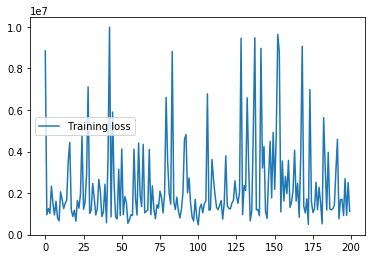

In [121]:
#####################
# Plot preds and performance
#####################
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

# plt.plot(y_pred.cpu().detach().numpy(), label="Preds")
# plt.plot(y_train.cpu().detach().numpy(), label="labels")
# plt.legend()
# plt.show() 



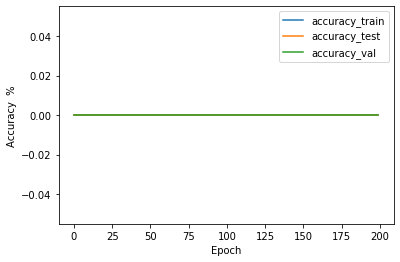

In [41]:
####################
# Plot preds and performance
####################
plt.plot(accuracy_train, label="accuracy_train")
plt.plot(accuracy_test, label="accuracy_test")
plt.plot(accuracy_val, label="accuracy_val")
plt.xlabel('Epoch')
plt.ylabel('Accuracy  %')
plt.legend()
plt.show()

In [ ]:
train_predicts, train_labels, accuracy = predict(model, train_loader)
cm = metrics.confusion_matrix(train_labels, train_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()

In [ ]:
test_predicts, test_labels, accuracy = predict(model, test_loader)
cm = metrics.confusion_matrix(test_labels, test_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()

In [ ]:
val_predicts, val_labels, accuracy = predict(model, val_loader)
cm = metrics.confusion_matrix(val_labels, val_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()